In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import peft
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl.trainer.grpo_config import GRPOConfig
from trl.trainer.grpo_trainer import GRPOTrainer
from sentiment import SentimentClassifier
from tqdm import tqdm
import json

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load reward model

In [4]:
classifier = SentimentClassifier(
    model_name='google/embeddinggemma-300m',
    hidden_size=10,
    device=device,
)
classifier.load_head('data/sentiment_head.pt')

# Prepare dataset

In [5]:
imdb = datasets.load_dataset('imdb')

rng = random.Random(42)


def format_prompt(sample):
    words = sample['text'].split()[: rng.randint(2, 6)]
    return {'prompt': ' '.join(words)}


train_data = imdb['train'].filter(lambda row: len(row['text']) > 200)
train_data = train_data.map(format_prompt, remove_columns=train_data.column_names)
train_data

Dataset({
    features: ['prompt'],
    num_rows: 24895
})

In [6]:
query_history = []
scores_history = []


def compute_reward(prompts: list[str], completions: list[str], **kwargs) -> list[float]:
    full_texts = [p + c for p, c in zip(prompts, completions)]

    inputs = classifier.tokenizer(
        full_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt',
    ).to(device)
    with torch.no_grad():
        logits = classifier(**inputs)
    scores = logits.cpu().tolist()

    query_history.append(full_texts)
    scores_history.append(scores)

    return scores

# Train

In [7]:
tokenizer = AutoTokenizer.from_pretrained('lvwerra/gpt2-imdb')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

policy_model = AutoModelForCausalLM.from_pretrained('lvwerra/gpt2-imdb', device_map=device)

In [8]:
prompt = 'This movie'
inputs = tokenizer([prompt] * 5, return_tensors='pt', padding=True).to(device)
with torch.no_grad():
    ids = policy_model.generate(**inputs, max_new_tokens=15, do_sample=True)

baseline_texts = [tokenizer.decode(i, skip_special_tokens=True) for i in ids]
baseline_scores = classifier.predict(baseline_texts).cpu().tolist()

for text, score in zip(baseline_texts, baseline_scores):
    print(f'{score:.3f}: {text}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.574: This movie is not recommended for young children. It isn't scary for children. Not
0.005: This movie didn't work well with me because it was so boring that I couldn't
0.914: This movie is really about the relationship between a young black man with an African heritage (
0.002: This movie is absolutely rubbish. I didn't like it because the first fifteen minutes were
0.018: This movie started out well. It was so slow, the actors all seemed tired and


In [9]:
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM,
    r=32,
    lora_alpha=32,
    lora_dropout=0.0,
    inference_mode=False,
    target_modules=['c_attn', 'c_proj', 'c_fc'],
)

training_args = GRPOConfig(
    output_dir='./grpo_output_2',
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    num_generations=8,
    max_completion_length=45,
    max_steps=200,
    logging_steps=10,
)

trainer = GRPOTrainer(
    model=policy_model,
    reward_funcs=compute_reward,
    args=training_args,
    train_dataset=train_data,
    processing_class=tokenizer,
    peft_config=peft_config,
)

/workspace/dl/.venv/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [10]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,0.031800
20,0.008700
30,-0.008700
40,0.009900
50,-0.005200
60,-0.006600
70,-0.021200
80,-0.004000
90,-0.044100
100,-0.050700


TrainOutput(global_step=200, training_loss=-0.023870783001184462, metrics={'train_runtime': 316.1099, 'train_samples_per_second': 40.492, 'train_steps_per_second': 0.633, 'total_flos': 0.0, 'train_loss': -0.023870783001184462})

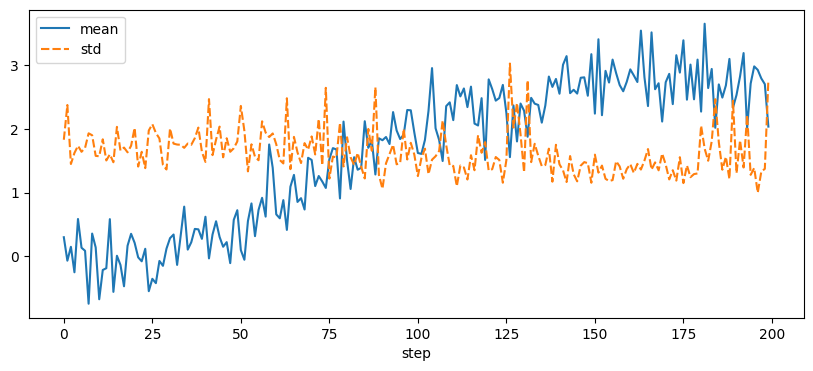

In [11]:
scores_history_df = pd.DataFrame(scores_history).T
scores_df = pd.DataFrame(
    {
        'mean': scores_history_df.mean(axis=0),
        'std': scores_history_df.std(axis=0),
    }
)
scores_df.index.rename('step', inplace=True)

plt.figure(figsize=(10, 4))
sns.lineplot(data=scores_df)

# plt.grid(True)
plt.show()

In [12]:
trainer.save_model('./adapters-again-2')

In [13]:
with open('data/queries_and_scores_2.json', 'w') as out:
    json.dump({'query_history': query_history, 'scores_history': scores_history}, out)

# Evaluate

In [14]:
prompts = [
    'This movie was',
    'I watched this film',
    'The acting in',
    'Whoever wrote',
    'At first I thought',
    'It was',
    'The director really',
    'I have to say',
    'One of the best',
    'Not sure about',
    'The story',
    'I really enjoyed',
    'This film is',
    'Honestly this movie',
    'The cinematography',
    'What a great',
    'I was disappointed',
    'My favorite part',
    'The ending was',
    'Overall the film',
]

model = trainer.model
assert model
model.eval()


def generate(prompts):
    inputs = tokenizer(prompts, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        outputs = [model.generate(**inputs, max_new_tokens=100, do_sample=True) for _ in tqdm(range(10))]  # type: ignore
    outputs = torch.cat(outputs)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


finetuned_texts = generate(prompts)

model.disable_adapter_layers()  # type: ignore
original_texts = generate(prompts)
model.enable_adapter_layers()  # type: ignore

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


In [20]:
original_scores = classifier.predict(original_texts).cpu().tolist()
finetuned_scores = classifier.predict(finetuned_texts).cpu().tolist()

for prompt, orig, ft, os_, fs in zip(
    prompts[:20], original_texts, finetuned_texts, original_scores, finetuned_scores
):
    print(f'Prompt: {prompt}')
    print(f'  Original  ({os_:.3f}): {orig[:200]}')
    print(f'  Finetuned ({fs:.3f}): {ft[:200]}')
    print()

Prompt: This movie was
  Original  (0.035): This movie was funny. It wasn't the comedy, but everything. No one at this point in time could really get up and come up with a way to do such something on the big screen. That is the problem with thi
  Finetuned (0.791): This movie was a real disappointment. It didn't help me. I thought it was pretty boring. There were some parts of the story that felt very forced, but it is what it is. One of the best movies I have c

Prompt: I watched this film
  Original  (0.050): I watched this film in the 1990s, and after seeing it, everything went from bad to worst. Most of its plots are unoriginal (it seems that the producers are the most famous). They use "scrapbook" as a 
  Finetuned (0.991): I watched this film not knowing what I'd be missing. As a fan of the Irish comic styles I was blown away. This film is the perfect backdrop for seeing the great work of Paul Revere and his writing and

Prompt: The acting in
  Original  (0.060): The acting in "T

In [16]:
print(f'Mean original score:  {np.mean(original_scores):.3f}')
print(f'Mean finetuned score: {np.mean(finetuned_scores):.3f}')

Mean original score:  0.551
Mean finetuned score: 0.963


# Check reward inputs / outputs

In [17]:
step = 42

In [18]:
pd.set_option('display.max_colwidth', 100)
pd.DataFrame({'score': scores_history[step], 'query': query_history[step]}).head(50)

,score,query
0,-0.894364,This would have worked perfectly if there was a reluctance to include female characters in some ...
1,-1.363344,"This would have worked in a run of Real Rebels, BBC, Improv's show, but it's too simple to relat..."
2,-0.470553,"This would have worked out better if it hadn't. ""Badad"" combines the hilariousness with the orig..."
3,-1.975934,"This would have worked with the Louisiana governor, but the portrayal of Houri in history would ..."
4,-0.919288,This would have worked reasonably well. But the rest of the story is in the hands of another one...
5,-1.925905,This would have worked better if everyone on screen accepted the fact that a French actor would ...
6,-1.180284,This would have worked with Ell-Carl for an old drama 8 to 5. There has to be proof something ha...
7,-0.587625,This would have worked.<br /><br />The art was bright except when he was sitting next to me in t...
8,2.144110,I saw 'Descent' last night at Alan's. Our lives changed off-side and we had a dynamic relationsh...
9,0.419022,I saw 'Descent' last night and wanted to see it. I was all amateur on it (Hollywood was also!) -...


In [22]:
df = (
    pd.concat(  # type: ignore
        {
            step: pd.DataFrame(
                {
                    'score': scores,
                    'query': queries,
                }
            )
            for step, (scores, queries) in enumerate(zip(scores_history, query_history))
        },
        names=['step'],  # type: ignore
    )
    .reset_index('step')
    .reset_index(drop=True)
)
df['query_no'] = np.arange(len(df) // 8).repeat(8)

In [23]:
pd.set_option('display.max_colwidth', 80)
df

,step,score,query,query_no
0,0,1.860326,This movie is excellent and is prefixed by 9x action. Porsche also tries har...,0
1,0,0.517267,This movie is excellent and should have been better in 1983.<br /><br />Over...,0
2,0,5.009699,This movie is excellent and always will be enjoyed by many. It shows many wo...,0
3,0,0.951500,"This movie is excellent and when you realize this seat is not""funny"", that's...",0
4,0,3.661766,This movie is excellent and doesn't have time for hammy dialogue jokes. Yes ...,0
...,...,...,...,...
12795,199,5.457986,I have come to the refusal of the characters to tell this story. It has an O...,1599
12796,199,0.789399,I have no idea how they remember. It shows us how people identify with movie...,1599
12797,199,3.231547,"I have high hopes for your book!"" joins two people in an outstanding and pas...",1599
12798,199,2.503808,"I have three different friends, Anna's mom, and Leon's mom, and both of us e...",1599


<Axes: xlabel='score', ylabel='Count'>

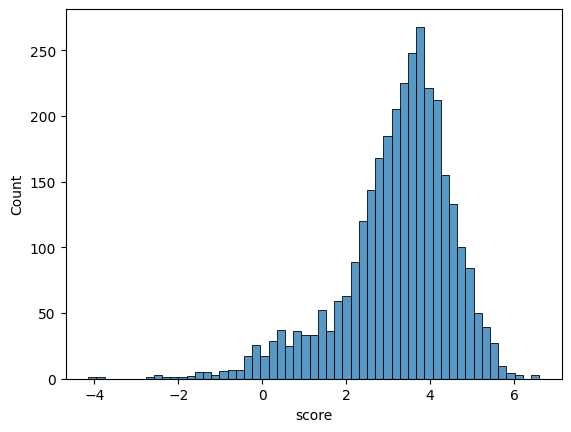

In [ ]:
sns.histplot(df.groupby('query_no')['score'].mean())

<Axes: xlabel='score', ylabel='Count'>

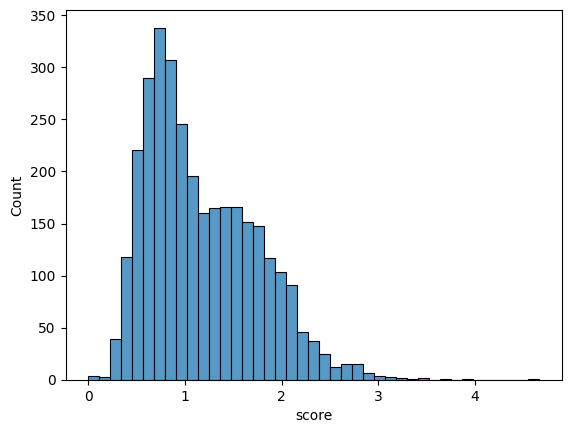

In [ ]:
sns.histplot(df.groupby('query_no')['score'].std())

In [ ]:
df.sort_values('score')

,step,score,query,query_no
1312,20,-10.480228,This was a really stupid movie.,164
12739,199,-8.546257,One of the worst films I've ever seen.,1592
23186,362,-8.158116,Bad acting.,2898
11524,180,-7.613754,"This movie was extremely boring. It is like something from ""Blue",1440
8255,128,-6.974349,This movie was so bad that I never saw it as a serious film as recommended.,1031
...,...,...,...,...
3817,59,7.979157,"A brilliant movie about family, guilt, and love! Highly recommended!",477
4938,77,7.982867,This show has been highly enjoyable and inspiring!,617
3238,50,8.232100,This movie is one of my favorites and inspiring! A touching film.,404
4071,63,8.269121,Such a masterpiece!,508


# Check that model has non-zero adapters

In [ ]:
assert model

print('Adapter modules:')
for name, param in model.named_parameters():
    if 'lora' in name and 'lora_A' in name:
        layer = name.split('.')[4]
        print(f'  Layer {layer}: {name.rsplit(".", 2)[0]}')

print(f'\nTrainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
print(f'Total:     {sum(p.numel() for p in model.parameters()):,}')

print('\nLoRA weight magnitudes:')
for name, param in model.named_parameters():
    if 'lora_B' in name:
        layer = name.split('.')[4]
        print(
            f'  Layer {layer} B: abs_mean={param.abs().mean():.6f}, abs_max={param.abs().max():.6f}'
        )

Adapter modules:
  Layer 0: base_model.model.transformer.h.0.attn.c_attn.lora_A
  Layer 0: base_model.model.transformer.h.0.attn.c_proj.lora_A
  Layer 0: base_model.model.transformer.h.0.mlp.c_fc.lora_A
  Layer 0: base_model.model.transformer.h.0.mlp.c_proj.lora_A
  Layer 1: base_model.model.transformer.h.1.attn.c_attn.lora_A
  Layer 1: base_model.model.transformer.h.1.attn.c_proj.lora_A
  Layer 1: base_model.model.transformer.h.1.mlp.c_fc.lora_A
  Layer 1: base_model.model.transformer.h.1.mlp.c_proj.lora_A
  Layer 2: base_model.model.transformer.h.2.attn.c_attn.lora_A
  Layer 2: base_model.model.transformer.h.2.attn.c_proj.lora_A
  Layer 2: base_model.model.transformer.h.2.mlp.c_fc.lora_A
  Layer 2: base_model.model.transformer.h.2.mlp.c_proj.lora_A
  Layer 3: base_model.model.transformer.h.3.attn.c_attn.lora_A
  Layer 3: base_model.model.transformer.h.3.attn.c_proj.lora_A
  Layer 3: base_model.model.transformer.h.3.mlp.c_fc.lora_A
  Layer 3: base_model.model.transformer.h.3.mlp.c_pro